/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using r

Best parameters found:  OrderedDict([('max_depth', 12), ('max_features', 3), ('max_leaf_nodes', 16), ('min_impurity_decrease', 0.0001), ('min_samples_leaf', 4), ('min_samples_split', 4), ('n_estimators', 100)])
Best score achieved:  0.7632145764197608


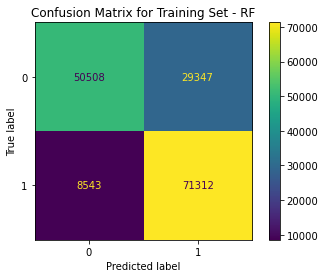

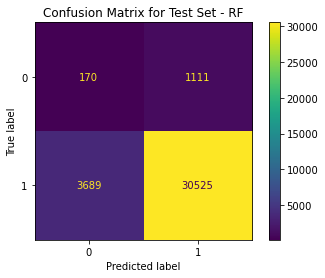

Classification Report for Training Set - RF:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73     79855
           1       0.71      0.89      0.79     79855

    accuracy                           0.76    159710
   macro avg       0.78      0.76      0.76    159710
weighted avg       0.78      0.76      0.76    159710


Classification Report for Test Set - RF:
              precision    recall  f1-score   support

           0       0.04      0.13      0.07      1281
           1       0.96      0.89      0.93     34214

    accuracy                           0.86     35495
   macro avg       0.50      0.51      0.50     35495
weighted avg       0.93      0.86      0.90     35495



NameError: name 'lgb' is not defined

In [ ]:
import pandas as pd
import numpy as np
import boto3
import sagemaker
from sklearn.pipeline import make_pipeline, Pipeline
from skopt.space import Integer, Real
from skopt import BayesSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt

## get training and testing data from the s3 bucket
x_train_file_path = 's3://ads508-20240325131610-mi4zt/training_data/X_train_smote.csv'
y_train_file_path = 's3://ads508-20240325131610-mi4zt/training_data/y_train_smote.csv'
x_test_file_path = 's3://ads508-20240325131610-mi4zt/training_data/X_test.csv'
y_test_file_path = 's3://ads508-20240325131610-mi4zt/training_data/y_test.csv'
X_train = pd.read_csv(x_train_file_path)
y_train = pd.read_csv(y_train_file_path)
X_test = pd.read_csv(x_test_file_path)
y_test = pd.read_csv(y_test_file_path)

## Data needs to be scaled
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter space for Bayesian optimization
search_spaces = {
    'n_estimators': Integer(50, 100),  # Range between 25 and 75
    'max_depth': Integer(6, 12),  # Range between 2 and 4
    'min_samples_split': Integer(2, 4),  # Range between 2 and 3
    'min_samples_leaf': Integer(1, 4),  # Range between 5 and 10
    'max_features':  Integer(1, 5), # Range between 1 and 5
    'max_leaf_nodes': Integer(8, 16),  # Range between 3 and 5
    'min_impurity_decrease': Real(0.0001, 0.01, "log-uniform"),  # Log-uniform distribution between 0.0001 and 0.01
}

rf = RandomForestClassifier(random_state=42)
# Set up the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=search_spaces,
    n_iter=50,  # Reduced for quicker execution, adjust as needed
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Perform the hyperparameter search
bayes_search.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best parameters found: ", bayes_search.best_params_)
print("Best score achieved: ", bayes_search.best_score_)
# Make predictions on both training and testing sets using the best model
y_pred_train = bayes_search.predict(X_train_scaled)
y_pred_test = bayes_search.predict(X_test_scaled)

# Generate and display confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

labels = bayes_search.best_estimator_.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

cmplot_train.plot()
plt.title('Confusion Matrix for Training Set - RF')
plt.show()

cmplot_test.plot()
plt.title('Confusion Matrix for Test Set - RF')
plt.show()

# Generate classification reports
train_report = classification_report(y_train, y_pred_train)
test_report = classification_report(y_test, y_pred_test)

print("Classification Report for Training Set - RF:")
print(train_report)
print("\nClassification Report for Test Set - RF:")
print(test_report)



# Define the parameter space for Bayesian optimization
search_spaces = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'num_leaves': Integer(20, 40),
    'max_depth': Integer(3, 10),
    'min_child_samples': Integer(100, 500),
    'subsample': Real(0.5, 1.0)
}
# Initialize the LightGBM classifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Set up the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=search_spaces,
    n_iter=10,  # Reduced for quicker execution, adjust as needed
    cv=5,
    n_jobs=-1,
    random_state=42
)
y_train = y_train['churn'].ravel()
# Perform the hyperparameter search
bayes_search.fit(X_train_scaled, y_train)


# Best parameters and score
print("Best parameters found: ", bayes_search.best_params_)
print("Best score achieved: ", bayes_search.best_score_)
# Make predictions on both training and testing sets using the best model
y_pred_train = bayes_search.predict(X_train_scaled)
y_pred_test = bayes_search.predict(X_test_scaled)

# Generate and display confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

labels = bayes_search.best_estimator_.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

cmplot_train.plot()
plt.title('Confusion Matrix for Training Set - LGBM')
plt.show()

cmplot_test.plot()
plt.title('Confusion Matrix for Test Set - LGBM')
plt.show()

# Generate classification reports
train_report = classification_report(y_train, y_pred_train)
test_report = classification_report(y_test, y_pred_test)

print("Classification Report for Training Set - LGBM:")
print(train_report)
print("\nClassification Report for Test Set - LGBM:")
print(test_report)

# Get feature importances from the best LightGBM model
best_lgbm = bayes_search.best_estimator_
importances = best_lgbm.feature_importances_
feature_names = X_train.columns
# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances - LightGBM")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center", color='skyblue')
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

X_train['Volumn'] = X_train['product_length_cm'] * X_train['product_height_cm'] * X_train['product_width_cm']
X_test['Volumn'] = X_test['product_length_cm'] * X_test['product_height_cm'] * X_test['product_width_cm']
X_train_new = X_train.drop(columns = ['freight_value', 'payment_value', 'product_length_cm', 'product_height_cm', 'product_width_cm'])
X_test_new = X_test.drop(columns = ['freight_value', 'payment_value', 'product_length_cm', 'product_height_cm', 'product_width_cm'])

## Data needs to be scaled
scaler_new = StandardScaler()
scaler_new.fit(X_train_new)
X_train_scaled_new = scaler_new.transform(X_train_new)
X_test_scaled_new = scaler_new.transform(X_test_new)

# Define the parameter space for Bayesian optimization
search_spaces_2 = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'num_leaves': Integer(20, 40),
    'max_depth': Integer(3, 10),
    'min_child_samples': Integer(100, 500),
    'subsample': Real(0.5, 1.0)
}
# Initialize the LightGBM classifier
lgbm_2 = lgb.LGBMClassifier(random_state=42)

# Set up the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=lgbm_2,
    search_spaces=search_spaces_2,
    n_iter=10,  # Reduced for quicker execution, adjust as needed
    cv=5,
    n_jobs=-1,
    random_state=42
)
# y_train = y_train['churn'].ravel()
# Perform the hyperparameter search
bayes_search.fit(X_train_scaled_new, y_train)


# Best parameters and score
print("Best parameters found: ", bayes_search.best_params_)
print("Best score achieved: ", bayes_search.best_score_)
# Make predictions on both training and testing sets using the best model
y_pred_train_new = bayes_search.predict(X_train_scaled_new)
y_pred_test_new = bayes_search.predict(X_test_scaled_new)

# Generate and display confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train_new)
cm_test = confusion_matrix(y_test, y_pred_test_new)

labels = bayes_search.best_estimator_.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

cmplot_train.plot()
plt.title('Confusion Matrix for Training Set - LGBM')
plt.show()

cmplot_test.plot()
plt.title('Confusion Matrix for Test Set - LGBM')
plt.show()

# Generate classification reports
train_report = classification_report(y_train, y_pred_train_new)
test_report = classification_report(y_test, y_pred_test_new)

print("Classification Report for Training Set - LGBM:")
print(train_report)
print("\nClassification Report for Test Set - LGBM:")
print(test_report)